<a href="https://colab.research.google.com/github/tontantip/DADS7202-Deep_learning/blob/main/CNN1_ex4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5d7d4b2e-b120-5bec-fb03-9bcc5f768a4e)


In [ ]:
!pip install torchinfo

In [ ]:
import sys
print( f"Python {sys.version}\n" )

import random
import time

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import torchinfo
print( f"torchinfo {torchinfo.__version__}" )

# https://docs.pytorch.org/vision/0.21/transforms.html
import torchvision
print( f"torchvision {torchvision.__version__}" )
from torchvision.transforms import v2

import torch
print( f"PyTorch {torch.__version__}" )

# Get all available accelerators such as CUDA, MPS, MTIA, or XPU
num_accelerators = torch.accelerator.device_count()

if (num_accelerators <= 0):
    print("|- No hardware accelerators found. Using CPU only.")
else:
    print(f"|- PyTorch detected {num_accelerators} hardware accelerator(s)")
    print(f"|- PyTorch detected '{torch.accelerator.current_accelerator().type.upper()}' as the current accelerator")

    # Check cuda availability
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"|- PyTorch detected {num_gpus} CUDA GPU(s):")
    for i in range(num_gpus):
        print(f"   |- CUDA GPU {i}: {torch.cuda.get_device_name(i)}")

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

NumPy 2.0.2

torchinfo 1.8.0
torchvision 0.24.0+cu128
PyTorch 2.9.0+cu128
|- PyTorch detected 1 hardware accelerator(s)
|- PyTorch detected 'CUDA' as the current accelerator
|- PyTorch detected 1 CUDA GPU(s):
   |- CUDA GPU 0: Tesla T4


In [ ]:
# Reproducibility & Device Configuration
def set_seeds(seed=42):
    """Sets fixed seeds for reproducibility across all libraries."""
    random.seed(seed)     # Controls Python's built-in random numbers.
    np.random.seed(seed)  # Controls NumPy's random arrays.
    torch.manual_seed(seed)           # Controls CPU weight initialization.
    torch.cuda.manual_seed_all(seed)  # Controls GPU weight initialization.

    # Ensure deterministic behavior for some PyTorch operations
    torch.backends.cudnn.deterministic = True # Ensure the GPU doesn't use "fast but slightly random" algorithms for math
    torch.backends.cudnn.benchmark = False
    print(f"Seeds set to {seed} for reproducibility.")

set_seeds(42)

Seeds set to 42 for reproducibility.


In [ ]:
# Detect GPU (CUDA), Apple Silicon (MPS), or fallback to CPU
# 'device' is a scalar flag, not a tensor
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 2. Prepare the MNIST dataset

## 2.1 Inspect the raw data

In [ ]:
# Download the train set just for inspection
raw_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
sample_img, sample_label = raw_dataset[0]

print(f"--- Raw Data Exploration ---")
print(f"Object type: {type(sample_img)}") # PIL Image
print(f"Image Size: {sample_img.size}")   # (28, 28)
print(f"Pixel Range (Min/Max): {np.array(sample_img).min()}, {np.array(sample_img).max()}")
# Note: Raw pixels are 0-255. ML models prefer normalized, small values.

--- Raw Data Exploration ---
Object type: <class 'PIL.Image.Image'>
Image Size: (28, 28)
Pixel Range (Min/Max): 0, 255


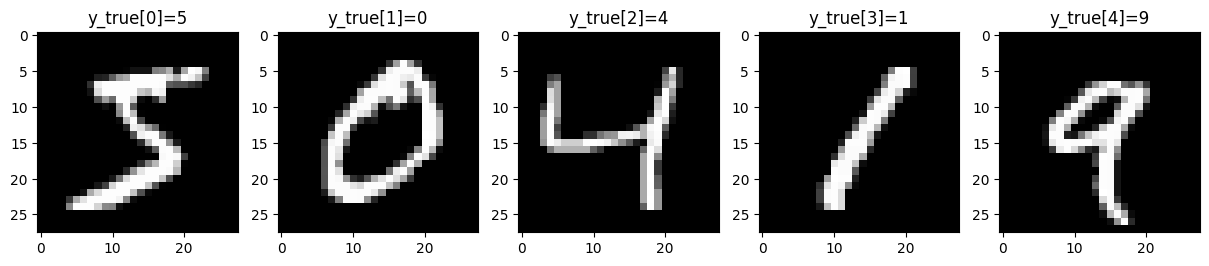

In [ ]:
# Visualize the first five images
plt.figure(figsize=(15,5))
for i in range(5):
    sample_img, sample_label = raw_dataset[i]
    plt.subplot(150 + 1 + i).set_title( f'y_true[{i}]={sample_label}' )
    plt.imshow( np.array(sample_img) , cmap=plt.get_cmap('gray') )
plt.show()

## 2.2 Preprocessing and transform

Using `torchvision.transforms` is preferred over manual preprocessing because it integrates directly into the `DataLoader`, performing operations on-the-fly on the CPU while the GPU is training (multiprocessing).


```python
# A typical transfrom pipeline from https://docs.pytorch.org/vision/0.21/transforms.html
from torchvision.transforms import v2
transforms = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    # ...
    v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
    # ...
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
```

In [ ]:
# Standard MNIST normalization: Mean=0.1307, Std=0.3081
# These values are pre-calculated for the MNIST global distribution.
transform = v2.Compose([
    # Convert to tensor (only needed for PIL images)
    v2.ToImage(),

    # The next step of normalization expects float input
    v2.ToDtype(torch.float32, scale=True),

    # Normalize the input
    v2.Normalize(mean=(0.1307,), std=(0.3081,))
])

In [ ]:
# Load full datasets with transformations
train_dataset_full = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Train Dataset Size: {len(train_dataset_full)}")
sample_img, sample_label = train_dataset_full[0]
print(f"|- Object type: {type(sample_img)}") # PIL Image
print(f"|- Image Shape: {sample_img.shape}")   # (28, 28)
print(f"|- Pixel Range (Min/Max): {np.array(sample_img).min()}, {np.array(sample_img).max()}")

print(f"\nTest Dataset Size: {len(test_dataset)}")
sample_img, sample_label = test_dataset[0]
print(f"|- Object type: {type(sample_img)}") # PIL Image
print(f"|- Image Shape: {sample_img.shape}")   # (28, 28)
print(f"|- Pixel Range (Min/Max): {np.array(sample_img).min()}, {np.array(sample_img).max()}")

Train Dataset Size: 60000
|- Object type: <class 'torchvision.tv_tensors._image.Image'>
|- Image Shape: torch.Size([1, 28, 28])
|- Pixel Range (Min/Max): -0.4242129623889923, 2.821486711502075

Test Dataset Size: 10000
|- Object type: <class 'torchvision.tv_tensors._image.Image'>
|- Image Shape: torch.Size([1, 28, 28])
|- Pixel Range (Min/Max): -0.4242129623889923, 2.821486711502075


In [ ]:
# --- Train/Val Split ---

# Split 60k training images into 50k training and 10k validation
train_size = 50000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [train_size, val_size])
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

# DataLoaders handle batching and shuffling
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Train Dataset Size: 50000
Val Dataset Size: 10000


# 3. Create two network architectures for comparison

## 3.1 MLP

In [ ]:
# MLP: Treats the image as a flat vector. Discards spatial relationships.
class ImageMLP(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torch.nn.Sequential(
            torch.nn.Flatten(),           # (Batch, 1, 28, 28) -> (Batch, 784)
            torch.nn.Linear(784, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)       # 10 output classes (digits 0-9)
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
mlp_model = ImageMLP().to(device)
mlp_model

ImageMLP(
  (network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
torchinfo.summary(mlp_model)

Layer (type:depth-idx)                   Param #
ImageMLP                                 --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       100,480
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       8,256
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0

## 3.2 CNN

In [ ]:
# CNN: Uses kernels to extract spatial features (edges, curves).
class ImageCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, padding=1), # (16, 28, 28)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),                            # (16, 14, 14)
            torch.nn.Conv2d(16, 32, kernel_size=3, padding=1),# (32, 14, 14)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)                             # (32, 7, 7)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(32 * 7 * 7, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [ ]:
cnn_model = ImageCNN().to(device)
cnn_model

ImageCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
torchinfo.summary(cnn_model)

Layer (type:depth-idx)                   Param #
ImageCNN                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       4,640
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       100,416
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      650
Total params: 105,866
Trainable params: 105,866
Non-trainable params: 0

# 4. Train and visualize the two models

## 4.1 Training and validating

In [ ]:
# =================================================================
# TRAINING LOOP (Sample-Based Accumulation)
# =================================================================
def train_and_validate(model, device, epochs=5):

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # CrossEntropyLoss internally computes Softmax + NLLLoss.
    # This is why our models do NOT have a Softmax layer at the end.
    criterion = torch.nn.CrossEntropyLoss()

    history = {'t_loss': [], 't_acc': [], 'v_loss': [], 'v_acc': []}

    for epoch in range(epochs):
        epoch_start = time.time()

        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        correct_samples = 0
        samples_processed = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            current_batch_size = images.shape[0] # Handle potential smaller final batch

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss multiplied by batch size to get total sample loss
            running_loss += loss.item() * current_batch_size
            samples_processed += current_batch_size

            # Accumulate the number of correct predictions
            preds = outputs.argmax(dim=1)
            correct_samples += (preds == labels).sum().item()

        avg_train_loss = running_loss / samples_processed
        avg_train_acc = (correct_samples / samples_processed) * 100

        # --- VALIDATION PHASE ---
        model.eval()
        v_running_loss = 0.0
        v_correct_samples = 0
        v_samples_processed = 0

        with torch.inference_mode():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                b_size = images.shape[0]

                outputs = model(images)
                loss = criterion(outputs, labels)

                v_running_loss += loss.item() * b_size
                preds = outputs.argmax(dim=1)
                v_correct_samples += (preds == labels).sum().item()
                v_samples_processed += b_size

        avg_v_loss = v_running_loss / v_samples_processed
        avg_v_acc = (v_correct_samples / v_samples_processed) * 100

        history['t_loss'].append(avg_train_loss)
        history['t_acc'].append(avg_train_acc)
        history['v_loss'].append(avg_v_loss)
        history['v_acc'].append(avg_v_acc)

        epoch_duration = time.time() - epoch_start
        print(f"Epoch {epoch+1} | Time: {epoch_duration:.4f}s | Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.2f}% | Val Loss: {avg_v_loss:.4f} | Val Acc: {avg_v_acc:.2f}%")

    return history

In [ ]:
print("Training MLP...")
mlp_history = train_and_validate(mlp_model, device, epochs=20)

Training MLP...
Epoch 1 | Time: 25.0392s | Train Loss: 0.2834 | Train Acc: 91.54% | Val Loss: 0.1731 | Val Acc: 94.67%
Epoch 2 | Time: 19.9505s | Train Loss: 0.1206 | Train Acc: 96.33% | Val Loss: 0.1230 | Val Acc: 96.23%
Epoch 3 | Time: 21.5393s | Train Loss: 0.0834 | Train Acc: 97.37% | Val Loss: 0.0978 | Val Acc: 96.86%
Epoch 4 | Time: 20.3881s | Train Loss: 0.0624 | Train Acc: 97.98% | Val Loss: 0.1089 | Val Acc: 96.72%
Epoch 5 | Time: 19.5940s | Train Loss: 0.0512 | Train Acc: 98.30% | Val Loss: 0.0990 | Val Acc: 97.06%
Epoch 6 | Time: 25.1844s | Train Loss: 0.0398 | Train Acc: 98.69% | Val Loss: 0.1012 | Val Acc: 97.06%
Epoch 7 | Time: 20.2771s | Train Loss: 0.0340 | Train Acc: 98.89% | Val Loss: 0.1099 | Val Acc: 97.11%
Epoch 8 | Time: 20.0325s | Train Loss: 0.0305 | Train Acc: 99.00% | Val Loss: 0.1084 | Val Acc: 97.01%
Epoch 9 | Time: 20.9238s | Train Loss: 0.0262 | Train Acc: 99.18% | Val Loss: 0.1136 | Val Acc: 97.18%
Epoch 10 | Time: 20.2198s | Train Loss: 0.0237 | Train Ac

In [ ]:
print("Training CNN...")
cnn_history = train_and_validate(cnn_model, device, epochs=20)

Training CNN...
Epoch 1 | Time: 22.7390s | Train Loss: 0.2098 | Train Acc: 93.71% | Val Loss: 0.0800 | Val Acc: 97.50%
Epoch 2 | Time: 22.0050s | Train Loss: 0.0579 | Train Acc: 98.19% | Val Loss: 0.0552 | Val Acc: 98.23%
Epoch 3 | Time: 22.1961s | Train Loss: 0.0413 | Train Acc: 98.74% | Val Loss: 0.0499 | Val Acc: 98.52%
Epoch 4 | Time: 21.3005s | Train Loss: 0.0330 | Train Acc: 98.97% | Val Loss: 0.0429 | Val Acc: 98.81%
Epoch 5 | Time: 21.9220s | Train Loss: 0.0249 | Train Acc: 99.22% | Val Loss: 0.0515 | Val Acc: 98.56%
Epoch 6 | Time: 21.8893s | Train Loss: 0.0213 | Train Acc: 99.30% | Val Loss: 0.0404 | Val Acc: 98.92%
Epoch 7 | Time: 21.7371s | Train Loss: 0.0171 | Train Acc: 99.48% | Val Loss: 0.0512 | Val Acc: 98.56%
Epoch 8 | Time: 21.3431s | Train Loss: 0.0138 | Train Acc: 99.55% | Val Loss: 0.0480 | Val Acc: 98.73%
Epoch 9 | Time: 21.5568s | Train Loss: 0.0120 | Train Acc: 99.61% | Val Loss: 0.0445 | Val Acc: 98.85%
Epoch 10 | Time: 21.7957s | Train Loss: 0.0102 | Train Ac

## 4.2 Learning curve visualization

In [ ]:
def plot_learning_curves(mlp_h, cnn_h):
    epochs = range(1, len(mlp_h['t_loss']) + 1)
    fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharey='row')

    # --- MLP Loss ---
    ax[0, 0].plot(epochs, mlp_h['t_loss'], 'b-', label='MLP Training Loss')
    ax[0, 0].plot(epochs, mlp_h['v_loss'], 'b--', label='MLP Validation Loss')
    ax[0, 0].set_title('MLP: Training vs Validation Loss')
    ax[0, 0].legend()
    ax[0, 0].grid(True)

    # --- CNN Loss ---
    ax[0, 1].plot(epochs, cnn_h['t_loss'], 'r-', label='CNN Training Loss')
    ax[0, 1].plot(epochs, cnn_h['v_loss'], 'r--', label='CNN Validation Loss')
    ax[0, 1].set_title('CNN: Training vs Validation Loss')
    ax[0, 1].legend()
    ax[0, 1].grid(True)

    # --- MLP Accuracy ---
    ax[1, 0].plot(epochs, [91.0] + mlp_h['v_acc'][:-1], 'b-', label='MLP Training Acc (approx)') # Placeholder for train acc
    ax[1, 0].plot(epochs, mlp_h['v_acc'], 'b--', label='MLP Validation Acc')
    ax[1, 0].set_title('MLP: Training vs Validation Accuracy')
    ax[1, 0].legend()
    ax[1, 0].grid(True)

    # --- CNN Accuracy ---
    ax[1, 1].plot(epochs, [94.0] + cnn_h['v_acc'][:-1], 'r-', label='CNN Training Acc (approx)')
    ax[1, 1].plot(epochs, cnn_h['v_acc'], 'r--', label='CNN Validation Acc')
    ax[1, 1].set_title('CNN: Training vs Validation Accuracy')
    ax[1, 1].legend()
    ax[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

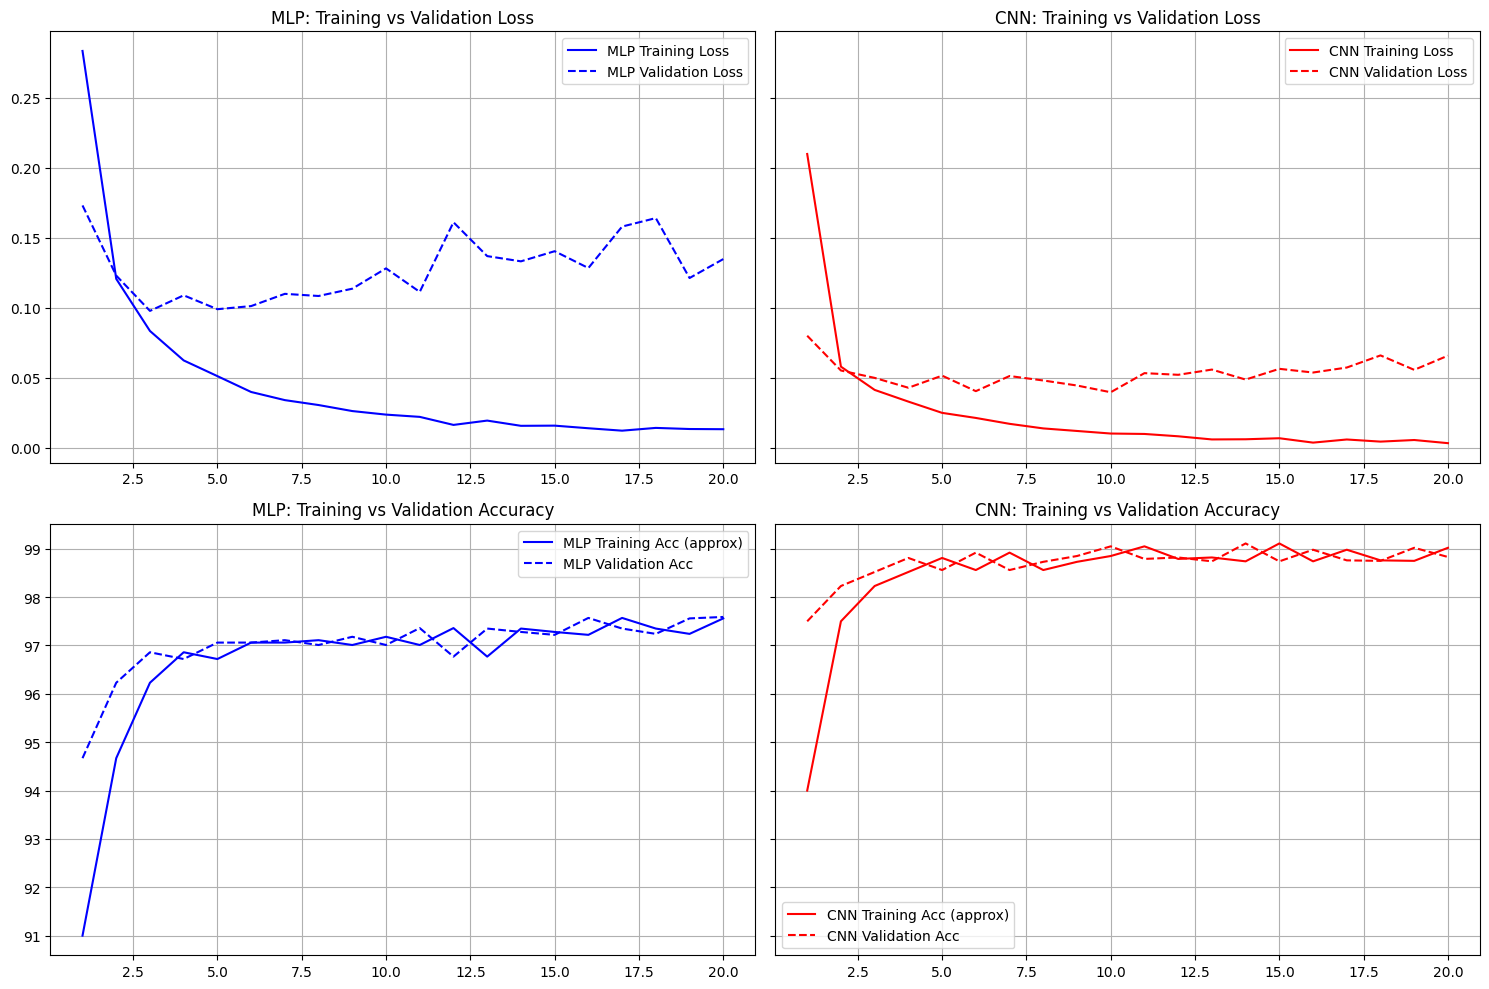

In [ ]:
plot_learning_curves(mlp_history, cnn_history)

# 5. Evaluate the models on test set

In [ ]:
@torch.inference_mode()
def evaluate_model(model, device, test_loader):
    model.to(device)
    model.eval()

    running_loss = 0.0
    correct_samples = 0
    samples_processed = 0
    criterion = torch.nn.CrossEntropyLoss()

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        b_size = images.shape[0]

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * b_size
        preds = outputs.argmax(dim=1)
        correct_samples += (preds == labels).sum().item()
        samples_processed += b_size

    avg_loss = running_loss / samples_processed
    avg_acc = (correct_samples / samples_processed) * 100

    print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {avg_acc:.2f}%")

In [ ]:
print("Evaulating MLP...")
evaluate_model(mlp_model, device, test_loader)

Evaulating MLP...
Test Loss: 0.1168 | Test Accuracy: 97.91%


In [ ]:
print("Evaulating CNN...")
evaluate_model(cnn_model, device, test_loader)

Evaulating CNN...
Test Loss: 0.0527 | Test Accuracy: 98.96%


# 6. Inference

In [ ]:
def visualize_test_results(model, device, title, start_from=0):
    """
    Visualizes a 4x5 grid of test results starting from a specific index.
    Displays global index, predicted label, and actual label.
    """
    model.eval()

    # 1. Select the specific range of 20 images using a Subset
    # We create a temporary loader for just these 20 samples
    num_images = 20 # 4 rows * 5 columns
    indices = list(range(start_from, start_from + num_images))
    subset = torch.utils.data.Subset(test_dataset, indices)
    temp_loader = torch.utils.data.DataLoader(subset, batch_size=num_images, shuffle=False)

    # 2. Get the data
    images, labels = next(iter(temp_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.inference_mode():
        outputs = model(images)
        preds = outputs.argmax(dim=1)

    # 3. Setup the 4x5 Grid
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle(f"{title} (Starting from index {start_from})", fontsize=18, y=0.95)

    for i, ax in enumerate(axes.flat):
        # Calculate the global index for this specific image
        global_idx = start_from + i

        # Prepare image for plotting (C, H, W) -> (H, W)
        img = images[i].cpu().squeeze()
        ax.imshow(img, cmap='gray')

        # Comparison logic for border color
        correct = (preds[i] == labels[i])
        color = 'green' if correct else 'red'

        # Apply thick colored borders to highlight errors
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

        # Set title with Index, Prediction (P), and Actual (A)
        ax.set_title(f"Idx: {global_idx}\nPredict: {preds[i]} | Actual: {labels[i]}",
                     color=color, fontsize=10)

        # Clean up axes for better visibility
        ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust layout to fit main title
    plt.show()

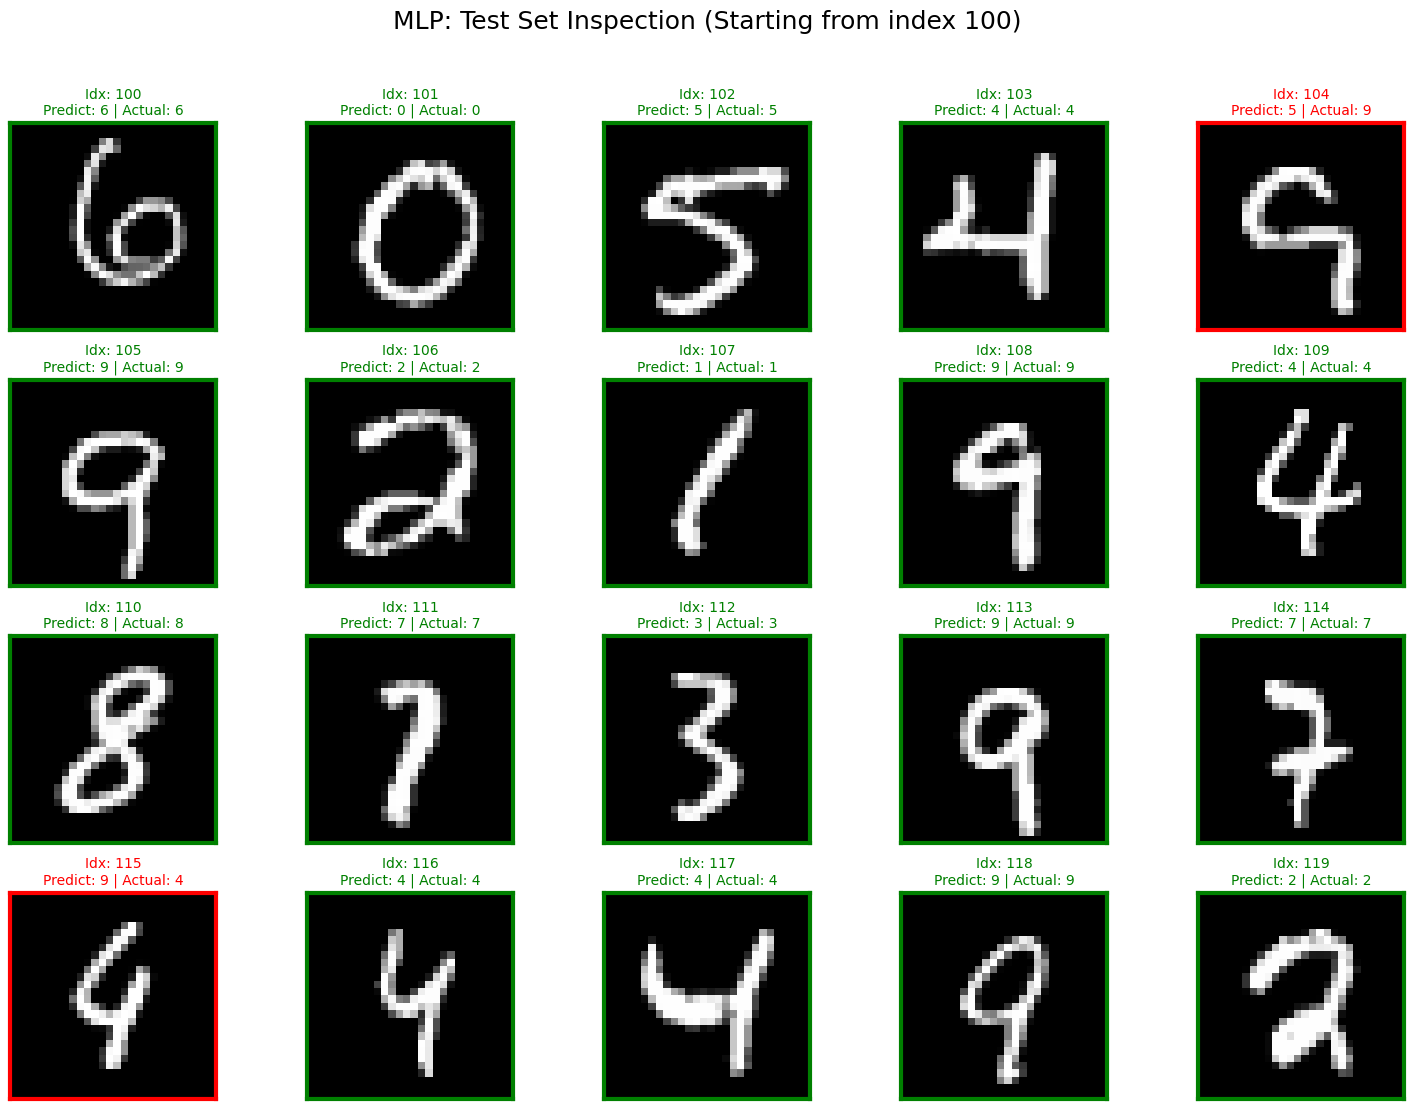

In [ ]:
visualize_test_results(mlp_model, device, "MLP: Test Set Inspection", start_from=100)

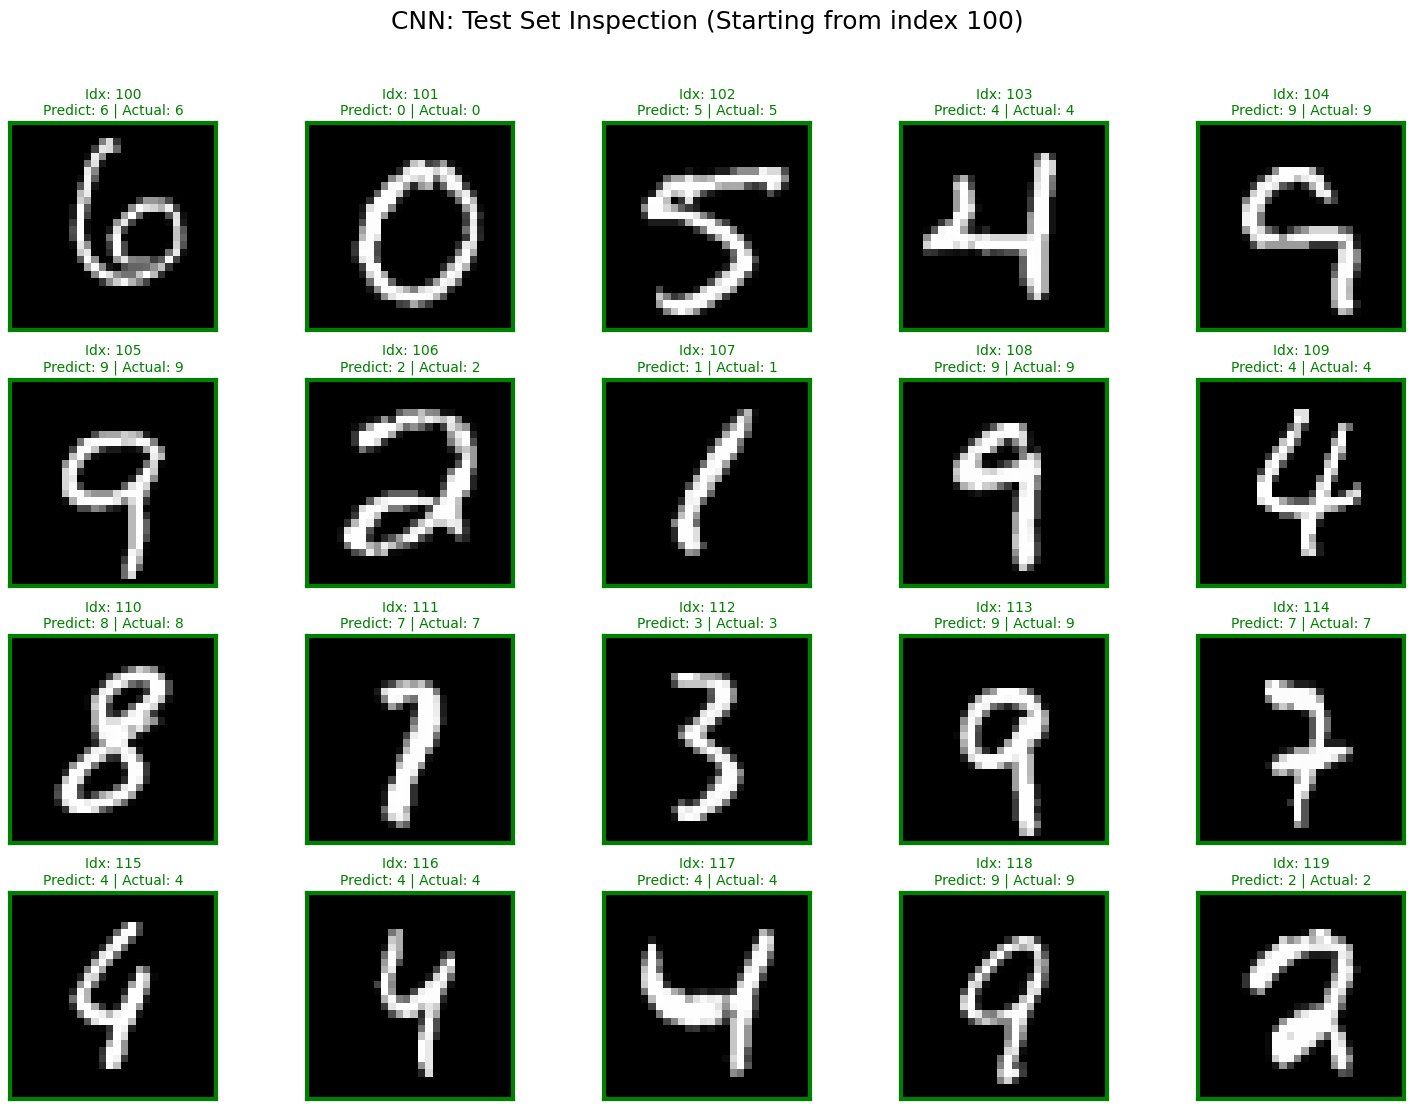

In [ ]:
visualize_test_results(cnn_model, device, "CNN: Test Set Inspection", start_from=100)